# Housing Price Prediction for houses in California Bay Area

The dataset contains different features such as age of the house, number of rooms, income of the household, proximity to the ocean etc., a Regression Machine Learning Model can be trained using these features to predict the house of a house.

## Importing the dependencies

In [95]:
import os
import tarfile
import urllib
from urllib.parse import urlparse
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import seaborn as sns


DATASET_URL = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"
cwd = os.getcwd()
DATASET_FOLDER_PATH = os.path.join(cwd, "dataset")

## Fetch and Load the dataset

In [2]:
def fetch_filename_from_url(dataset_url=DATASET_URL):
    """
    Returns the "file-name.ext" from a given url.
    """
    url_to_path = urlparse(dataset_url).path
    file_name = os.path.basename(url_to_path)
    return file_name

def fetch_dataset(dataset_url=DATASET_URL, dataset_folder_path=DATASET_FOLDER_PATH):
    """
    Downloads the dataset if not present and unpacks it
    """
    os.makedirs(dataset_folder_path, exist_ok=True)
    file_name = fetch_filename_from_url(dataset_url)

    if not os.path.isfile(file_name):
        tgz_path = os.path.join(dataset_folder_path, file_name)
        urllib.request.urlretrieve(dataset_url, tgz_path)
        dataset_tgz = tarfile.open(tgz_path)
        dataset_tgz.extractall(path=dataset_folder_path)
        dataset_tgz.close()

def load_dataset(dataset_url=DATASET_URL, dataset_folder_path=DATASET_FOLDER_PATH):
    """
    Returns the dataframe containing the dataset
    """
    file_name = fetch_filename_from_url(dataset_url).split(".")[0]
    csv_path = os.path.join(dataset_folder_path, file_name+".csv")
    return pd.read_csv(csv_path)

In [3]:
fetch_dataset()
housing_dataset = load_dataset()

# Exploring the dataset

In [4]:
# Each example is a block/group of houses
housing_dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Data Visualization:

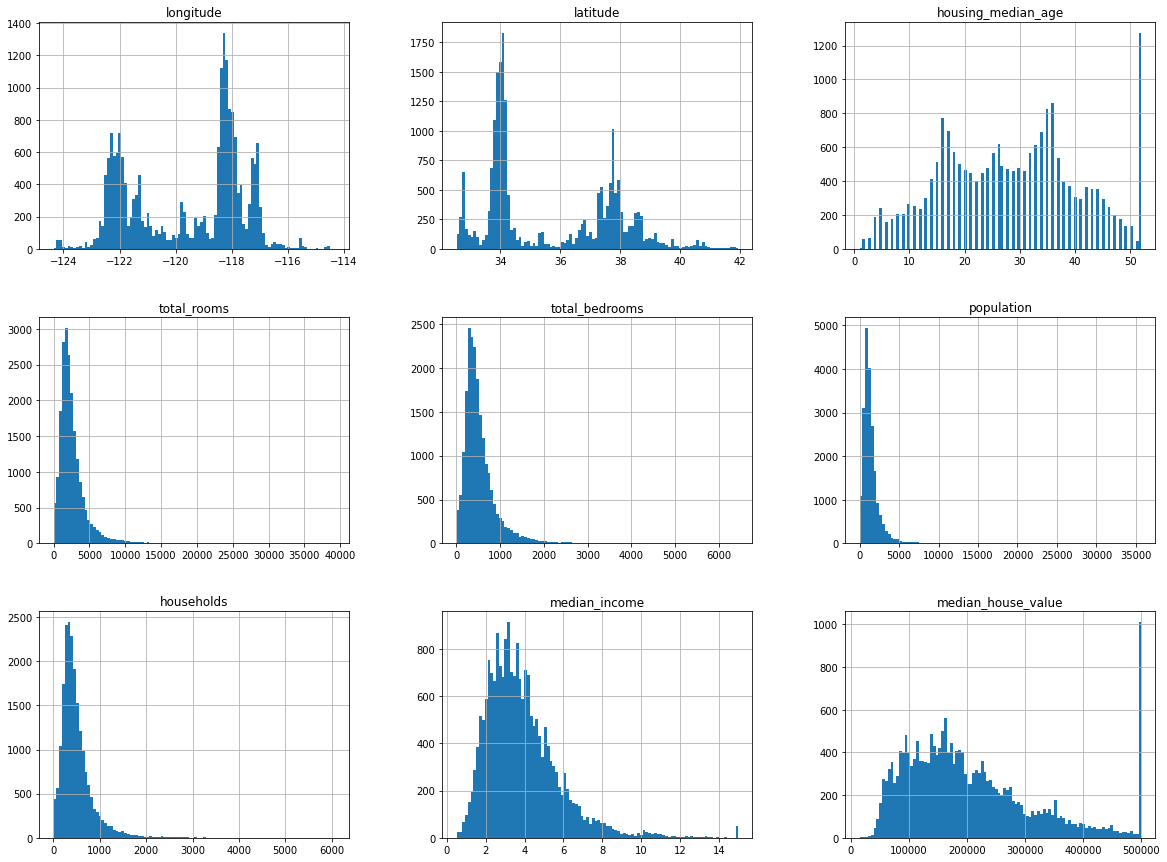

In [5]:
# Visualizing the distribution of the dataset
housing_dataset.hist(bins=100, figsize=(20,15))
plt.show()

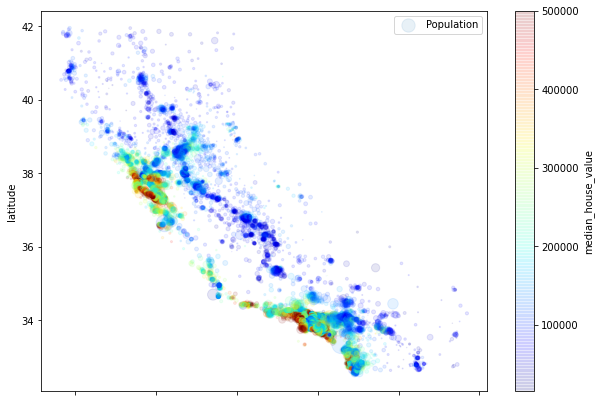

In [6]:
# Visualizing the location of the houses using Latitude and Longitude.
# The size of each point represents the population for that block;
# The color of each point represents the median house value in that block.

housing_dataset.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,
    s=housing_dataset["population"]/100, label="Population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

### Linear Correlation between the features:

In [7]:
# Correalation of all features wrt "median_house_value"
corr_matrix = housing_dataset.corr()
corr_house_value = corr_matrix["median_house_value"].sort_values(ascending=False)
corr_house_value

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

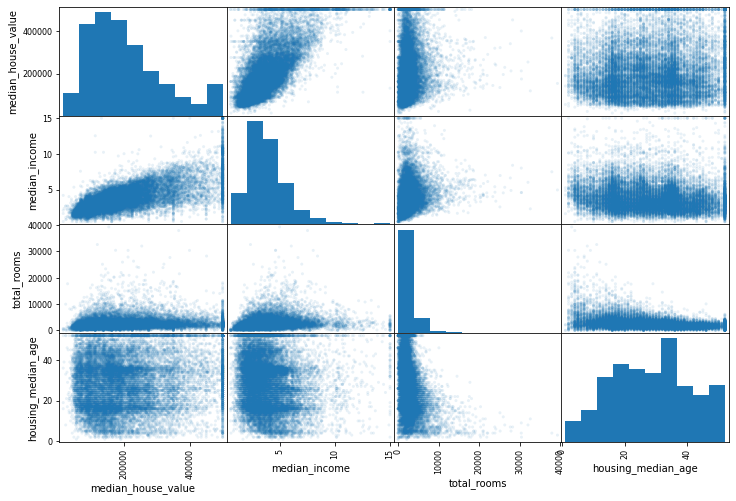

In [8]:
# Visualize the linear correlation between the features which are higly correlated to median_hosue_values
# As we can see, as median_income of the household increases, the median_house_value also increases.
# We cant see such patterns for other features.

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing_dataset[attributes], figsize=(12,8), alpha=0.1)
plt.show()

# Data Preprocessing

## Splitting the dataset into test, train sets:
- We have to make sure that our sets statisfy "Stratisfied sampling"  where we have to make sure that our test,train set have equal amount of data from different "strata"/groups
- We can use `cut` to sort data values into bins/categories
- `StratifiedShuffleSplit` returns stratified randomized sets/folds. These folds are made by preserving the percentage of samples for each class

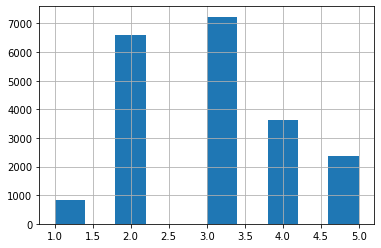

In [9]:
housing_dataset["income_cat"] = pd.cut(
                                housing_dataset["median_income"],
                                bins=[0., 1.5, 3.0, 4.5 , 6., np.inf],
                                labels=[1, 2, 3, 4, 5])
housing_dataset["income_cat"].hist()
plt.show()

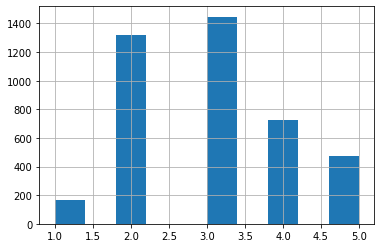

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# stratification is done based on the second arg; it returns the indexes for test and train splits
for train_index, test_index in strat_split.split(housing_dataset, housing_dataset["income_cat"]):
    strat_train_set = housing_dataset.loc[train_index]    
    strat_test_set = housing_dataset.loc[test_index]

# Since we startified based on "income_cat", the train,test sets also have same proporiton of examples from each category
strat_test_set["income_cat"].hist()
plt.show()

In [11]:
# Removing income_cat attribute
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Final sets for training and testing:
X_train = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"].copy()

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

del strat_train_set, strat_test_set

## Pipeline
- Fills in missing data
- Does feature scaling
- Deals with Categorical values

In [12]:
num_attribs = list(X_train.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

# Pipeline for numerical data alone
num_preprocessing_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# Pipeline for entire data by using ColumnTransformer for "ocean_proximity" data alone 
full_preprocessing_pipeline = ColumnTransformer([
        ("num", num_preprocessing_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train_prep = full_preprocessing_pipeline.fit_transform(X_train)
X_train_prep.shape

(16512, 13)

# Selecting and Training a Model:
Using GridSearchCV to choose the best regressor and their corresponding Hyperparameter. We are using a 3-fold CrossValidation which splits the X_train dataset into 3 folds, trianing 2 folds and validating it against the remianing fold. This is done 3 times ie(1 fold is left out as validator each time). Then their average scores are taken.

We have different combinations of hyperparameter given below; This gives us with 37 combinations; Thus we do 3-fold CV using each one of those combination; Thus we train and test for a total of 111 times.

In [61]:
pipeline = Pipeline([
    ("reg", LinearRegression)
])

parameters = [
    {
        "reg": [LinearRegression()],
    },
    {
        "reg": [DecisionTreeRegressor()],
        "reg__random_state": [42],
        "reg__max_features": [1,5,10],
        "reg__max_depth": [10,50],

    },
    {
        "reg": [RandomForestRegressor()],
        "reg__random_state": [42],
        "reg__max_features": [1,5,10],
        "reg__n_estimators": [10, 50, 100],
        "reg__max_depth": [10, 50, 100],

    },
    {
        "reg": [SVR()],
        "reg__kernel": ["linear"],
        "reg__C": [10,100,1000],
    }
]
grid_search = GridSearchCV(pipeline, parameters,scoring='neg_mean_squared_error', verbose=2, cv=3, n_jobs=10)
grid_search.fit(X_train_prep, y_train)

Fitting 3 folds for each of 37 candidates, totalling 111 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('reg',
                                        <class 'sklearn.linear_model._base.LinearRegression'>)]),
             n_jobs=10,
             param_grid=[{'reg': [LinearRegression()]},
                         {'reg': [DecisionTreeRegressor()],
                          'reg__max_depth': [10, 50],
                          'reg__max_features': [1, 5, 10],
                          'reg__random_state': [42]},
                         {'reg': [RandomForestRegressor(max_depth=50,
                                                        max_features=5,
                                                        random_state=42)],
                          'reg__max_depth': [10, 50, 100],
                          'reg__max_features': [1, 5, 10],
                          'reg__n_estimators': [10, 50, 100],
                          'reg__random_state': [42]},
                         {'reg': [SVR()], 'reg__C': [10, 100, 1000],
         

In [64]:
# The models and the hyperparameter that has a mean_square_error lesser than 51000 are given below:

grid_search_scores = grid_search.cv_results_
for mean_score, params in zip(grid_search_scores["mean_test_score"], grid_search_scores["params"] ):
    mean_score = np.sqrt(-mean_score)
    if mean_score < 51000:
        print("%.4f" % mean_score, params)

50743.9020 {'reg': RandomForestRegressor(max_depth=50, max_features=5, random_state=42), 'reg__max_depth': 50, 'reg__max_features': 5, 'reg__n_estimators': 50, 'reg__random_state': 42}
50360.5920 {'reg': RandomForestRegressor(max_depth=50, max_features=5, random_state=42), 'reg__max_depth': 50, 'reg__max_features': 5, 'reg__n_estimators': 100, 'reg__random_state': 42}
50547.3204 {'reg': RandomForestRegressor(max_depth=50, max_features=5, random_state=42), 'reg__max_depth': 50, 'reg__max_features': 10, 'reg__n_estimators': 50, 'reg__random_state': 42}
50398.1920 {'reg': RandomForestRegressor(max_depth=50, max_features=5, random_state=42), 'reg__max_depth': 50, 'reg__max_features': 10, 'reg__n_estimators': 100, 'reg__random_state': 42}
50743.9020 {'reg': RandomForestRegressor(max_depth=50, max_features=5, random_state=42), 'reg__max_depth': 100, 'reg__max_features': 5, 'reg__n_estimators': 50, 'reg__random_state': 42}
50360.5920 {'reg': RandomForestRegressor(max_depth=50, max_features=5,

### Best Model:
Thus the best model is a RandomForst Regressor with a max_depth=50, max features=5 , n_estimator=200

In [62]:
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('reg',
                 RandomForestRegressor(max_depth=50, max_features=5,
                                       random_state=42))])

# Visualzing the Output


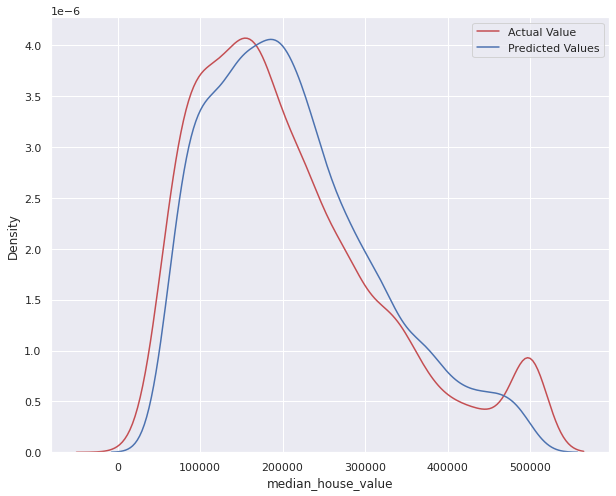

In [123]:
# The distribution of the Actual and Predicted value can be used to check if our model was good enough. But this is not the best way to visualize
sns.set(rc={'figure.figsize':(10,8)})
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_test_predict, hist=False, color="b", label="Predicted Values" , ax=ax1)
ax1.legend();

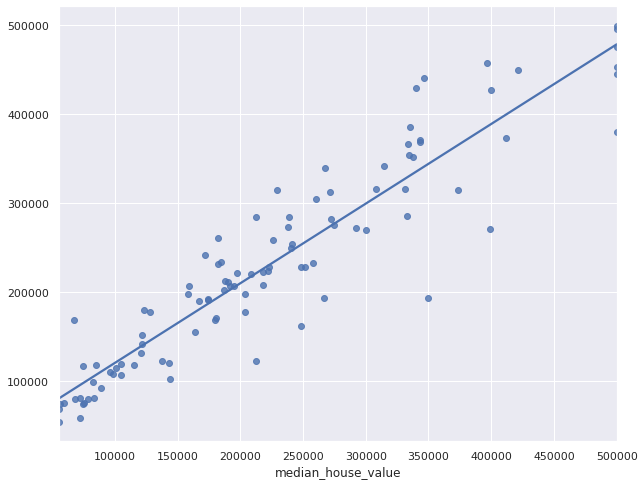

In [124]:
# The regplot can be used to visualize the linear relationship between the Actual and Predicted values: 
# As we can see that the points are close to the line and hence the model did a good job.
sns.set(rc={'figure.figsize':(10,8)})
sns.regplot(x=y_test[:100], y=y_test_predict[:100], ci=None, color="b")
plt.show()